# Homework 05 - More on DNNs

In this homework you will deepen your understanding of TensorFlow. You will implement a simple classifier for the MNIST dataset.    
 
Be aware that sometimes there are variable names in the provided code that need to align with variables that you define. You can either change my or your code.

In [1]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


### Load the dataset.

In [2]:
# TensorFlow has some popular datasets already included. 
# Check out https://www.tensorflow.org/api_docs/python/tf/keras/datasets.
# In this homework we will work with the popular MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Investigate the dataset.

**It is always important to understand the format and the count of the data you are dealing with.**  
**Please answer the following questions:**

Q: *How many training/test images does this dataset have?*  
A: 60000/10000

Q: *Which shape do the images have?*  
A: 28*28 pixel

Q: *In which range are the pixel values?*  
A: from 0 to 255

In [3]:
# You should make use of the following functions and properties.
# You can access the shape of an array 'arr' with 'arr.shape'.
# You can use 'np.max', 'np.min' to access the maximum or minimum of an array.
print(train_images.shape)
print(test_images.shape)
print(train_images[0].shape)
print(test_images[0].shape)
print(np.ptp(train_images))
np.min(train_images[0])

(60000, 28, 28)
(10000, 28, 28)
(28, 28)
(28, 28)
255


0

### Visualize the dataset.

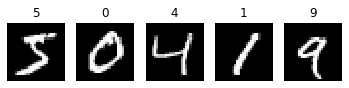

In [4]:
# It can also be helpful to have a proper look at specific samples of a dataset to understand what you are dealing with.
# Plot 5 samples with their corresponding label.

fig, ax = plt.subplots(1,5)
for i in range(5):
    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]
    ######################
    # printing it
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

### Build the TensorFlow dataset.

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# It makes sense to shuffle the training dataset.
train_dataset = train_dataset.shuffle(buffer_size=60000)
# Further we have seen that it is advantageous to train with mini-batches instead of one sample at a time.
train_dataset = train_dataset.batch(128)
# Let's have a look at how the elements of the dataset now look.
for elem in train_dataset:
    print(elem[0].shape)
    print(elem[1].shape)
    break
# The test dataset can be processed in full batch.
test_dataset = test_dataset.batch(10000)

(128, 28, 28)
(128,)


### Build the model.

In [0]:
# We will implement a simple fully connected feed forward neural network like the last time.
#
# Our network will have the following layers:
# Input : 784 units.
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.
# 
# Instead of implementing our own layer we can directly implement the network using pre-built layers 
# from TensorFlow.
# For that check out 'tf.keras.layers.Dense(units= , activation=)'. It is basically the same layer that we
# implemented by hand last time. Except that you can include the activation function into the layer.
# For activations functions check out 'tf.keras.activations'.

from tensorflow.keras.layers import Layer

class Model(Layer):
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.      
        self.hidden_one = tf.keras.layers.Dense(units= 256,
                                           activation= tf.keras.activations.sigmoid)
        self.hidden_two = tf.keras.layers.Dense(units= 256,
                                           activation= tf.keras.activations.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units= 10, 
                                    activation= tf.keras.activations.softmax)
        
    def call(self, x):
        # Define the forward step.
        ######################
        # Calling layers after each other.
        x = self.hidden_one(x)
        x = self.hidden_two(x)
        x = self.output_layer(x)
        return x


### Question:

*Q: How many parameters does this network have?*  
A: 269322 (268800 weights and 522 biases)

### Train the model.

In [0]:
tf.keras.backend.clear_session()
# Initialize the model.
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'.

# Instantiate Class 
model = Model()

#print('Nr. of Parameters', Model.count_params(self))
# Define Loss function
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce

# Define optimizer (and learning rate)
optimizer = tf.keras.optimizers.Adam() # standard parameters: learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,

# Initialize lists for later visualization.
train_steps = []
train_losses = []
train_accuracies = []
test_steps = []
test_losses = []
test_accuracies = []
step = 0

# We train for 3 epochs.
for epoch in range(3):
    for (x,t) in train_dataset:   
        # We need to reshape the input from [batchsize,28,28] to [batchsize,784].
        # 784 pixels = 1 picture
        x = tf.reshape(x, shape=(-1,784))

        # Further we need to transform the labels into a one-hot encoding.
        # Check out 'tf.one_hot'. 
        t = tf.one_hot(t, depth = 10)

        # Compute the output, loss and the gradients.
        with tf.GradientTape() as tape:
            output = model(x)
            train_loss = loss(t, output)
            gradients = tape.gradient(train_loss, model.trainable_variables)
        
        # After recording the gradients we can apply them to the 
        # variables.
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Compute the accuracy.
        accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]

        # Store loss and accuracy.
        train_accuracies.append(accuracy)
        train_losses.append(train_loss)
        
        # After each 25 training step we check the generalization to the test dataset.
        if step % 25 == 0:
            for (x,t) in test_dataset:
                # first compute output of the network for the test data
                x = tf.reshape(x, shape=(-1,784))
                t = tf.one_hot(t, depth = 10)
                output = model(x)

                # then compute loss and accuracy
                test_loss = loss(t, output)
                accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]

                # save for later visualisation
                test_steps.append(step)
                test_accuracies.append(accuracy)
                test_losses.append(test_loss)
        
        train_steps.append(step)
        step += 1

### Visualize the training progress.

Final Training Loss:  0.33921742
Final Test Loss:  0.24026684
Final Training Accuracy:  0.875
Final Test Accuracy:  0.9269
Best Test Accuracy:  0.9303


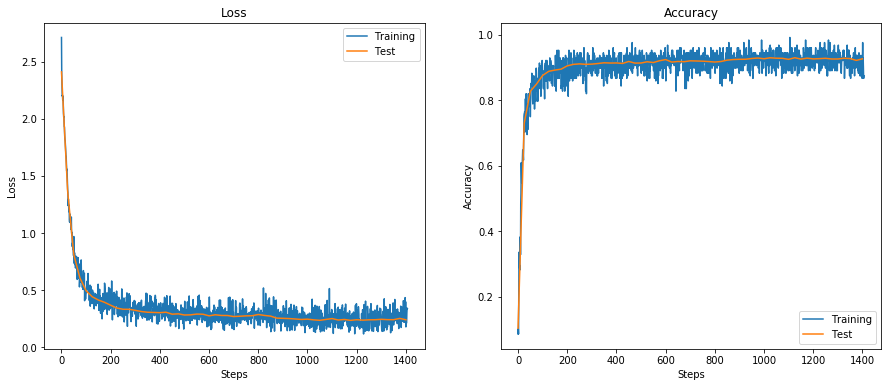

In [8]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.

# final scores
print('Final Training Loss: ',np.array(train_losses[-1]))
print('Final Test Loss: ',np.array(test_losses[-1]))
print('Final Training Accuracy: ',np.array(train_accuracies[-1]))
print('Final Test Accuracy: ',np.array(test_accuracies[-1]))
print('Best Test Accuracy: ',np.max(np.array(test_accuracies)))

# loss graph
fig = plt.figure(figsize=(15,6))
a=fig.add_subplot(1,2,1)
# training loss
plt.plot(train_steps, np.array(train_losses))
# testing loss
plt.plot(test_steps, np.array(test_losses))
plt.title('Loss')
plt.legend(['Training', 'Test'])
plt.xlabel("Steps")
plt.ylabel("Loss")

# accuracy graph
a=fig.add_subplot(1,2,2)
# training accuracy
plt.plot(train_steps, np.array(train_accuracies))
# test accuracy
plt.plot(test_steps, np.array(test_accuracies))
plt.title('Accuracy')
plt.legend(['Training', 'Test'])
plt.xlabel("Steps")
plt.ylabel("Accuracy")

plt.show()